In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
def build_master_df(data, label):
    frames = {}
    list_of_dfs = []

    for i in range(len(data['locations'])):
        coordinates = str(data['locations'][i]['coordinates'])
        country = data['locations'][i]['country']
        country_code = data['locations'][i]['country_code']
        province = data['locations'][i]['province']
        history = data['locations'][i]['history']
        df = pd.DataFrame(history, index=[0]).T
        df.reset_index(inplace=True)
        df.columns = ['date', 'count']
        df['date'] = pd.to_datetime(df['date'])
        df['country'] = country
        df['coordinates'] = coordinates
        df['country_code'] = country_code
        df['province'] = province

        country_key = country + '_' + str(i) # they key is never referenced elsewhere... just for building dict of df
        frames[country_key] = df # add to dict of dfs
        
    for key in frames.keys():
        list_of_dfs.append(frames[key]) # this needs to be key, not country key, IMPORTANT

    master_df = pd.concat(list_of_dfs)
    master_df = master_df.reset_index(drop=True)
    master_df['data_type'] = label

    return master_df

In [3]:
api_url = 'https://coronavirus-tracker-api.herokuapp.com/all'

In [4]:
json_data = pd.read_json(api_url)

In [5]:
confirmed_data = json_data['confirmed']
death_data = json_data['deaths']
recovered_data = json_data['recovered']

full_confirmed_df = build_master_df(confirmed_data, 'confirmed')
full_death_df = build_master_df(death_data, 'death')
full_recovered_df = build_master_df(recovered_data, 'recovered')

full_df = pd.concat([full_confirmed_df, full_death_df, full_recovered_df])
full_df.reset_index(drop=True, inplace=True)

In [30]:
full_df['date'].max() # last update was less than 24h ago

Timestamp('2020-03-14 00:00:00')

In [27]:
# this is the full dataframe, with confirmed/death/recovered data all together
# this is best for analyzing individual provinces/cities, where available.

full_df.head()

,date,count,country,coordinates,country_code,province,data_type
0,2020-01-22,2,Thailand,"{'lat': '15', 'long': '101'}",TH,,confirmed
1,2020-01-23,3,Thailand,"{'lat': '15', 'long': '101'}",TH,,confirmed
2,2020-01-24,5,Thailand,"{'lat': '15', 'long': '101'}",TH,,confirmed
3,2020-01-25,7,Thailand,"{'lat': '15', 'long': '101'}",TH,,confirmed
4,2020-01-26,8,Thailand,"{'lat': '15', 'long': '101'}",TH,,confirmed


In [28]:
full_df['country'].value_counts()

US             39114
China           5247
Australia       1431
Canada          1272
France           795
               ...  
Cruise Ship      159
Turkey           159
Aruba            159
Kazakhstan       159
Lithuania        159
Name: country, Length: 143, dtype: int64

In [29]:
# most data does not come with province/city, so it is null

full_df['province'].value_counts()

                       21465
Grand Princess           318
Diamond Princess         318
New Jersey               159
West Virginia            159
                       ...  
Fresno County, CA        159
Arkansas                 159
Henan                    159
St Martin                159
Delaware County, PA      159
Name: province, Length: 306, dtype: int64

In [7]:
# slim df is just full_df but with the countries aggregated. i wanted to see aggregations by country, not province

slim_full_df = full_df[['date', 'count', 'country', 'data_type']]
slim_full_df = slim_full_df.groupby(['date', 'country', 'data_type']).sum().reset_index()
slim_full_df.head()

,date,country,data_type,count
0,2020-01-22,Afghanistan,confirmed,0
1,2020-01-22,Afghanistan,death,0
2,2020-01-22,Afghanistan,recovered,0
3,2020-01-22,Albania,confirmed,0
4,2020-01-22,Albania,death,0


In [8]:
# this builds a summary dataframe w/ confirmed counts, death rates, recovery rates, etc

countries = []
confirmed_counts = []
death_counts = []
death_rates = []
recovered_counts = []
recovered_rates = []

for country in sorted(slim_full_df['country'].unique()):

    lookup_df = slim_full_df[slim_full_df['country'] == country]
    lookup_df = lookup_df[lookup_df['date'] == lookup_df['date'].max()]
    lookup_df = lookup_df[['data_type', 'count']].set_index('data_type')

    total = lookup_df.sum()[0]
    pct = lookup_df['count'] / int(lookup_df.loc['confirmed']['count'])
    lookup_df['pct'] = round(pct, 4)

    confirmed_count = int(lookup_df.loc['confirmed']['count'])
    death_count = int(lookup_df.loc['death']['count'])
    death_rate = lookup_df.loc['death']['pct']
    recovered_count = int(lookup_df.loc['recovered']['count'])
    recovered_rate = lookup_df.loc['recovered']['pct']

    countries.append(country)
    confirmed_counts.append(confirmed_count)
    death_counts.append(death_count)
    death_rates.append(death_rate)
    recovered_counts.append(recovered_count)
    recovered_rates.append(recovered_rate)

summary_df = pd.DataFrame({'country': countries, 'confirmed_count': confirmed_counts, 
              'death_count': death_counts, 'death_rate': death_rates,
             'recovered_count': recovered_counts, 'recovered_rate': recovered_rates,
             })

summary_df.set_index('country', inplace=True)

In [9]:
summary_df.head()

,confirmed_count,death_count,death_rate,recovered_count,recovered_rate
country,,,,,
Afghanistan,11,0,0.0000,0,0.0000
Albania,38,1,0.0263,0,0.0000
Algeria,37,3,0.0811,12,0.3243
Andorra,1,0,0.0000,1,1.0000
Antigua and Barbuda,1,0,0.0000,0,0.0000


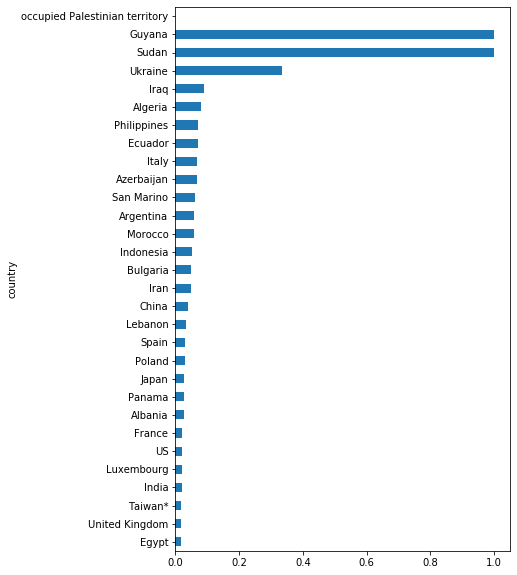

In [10]:
summary_df['death_rate'].sort_values()[-30:].plot.barh(figsize=(6, 10))

In [11]:
summary_df['death_rate'].sort_values()[-30:]

country
Egypt                             0.0183
United Kingdom                    0.0184
Taiwan*                           0.0189
India                             0.0196
Luxembourg                        0.0196
US                                0.0198
France                            0.0203
Albania                           0.0263
Panama                            0.0278
Japan                             0.0285
Poland                            0.0291
Spain                             0.0305
Lebanon                           0.0323
China                             0.0394
Iran                              0.0480
Bulgaria                          0.0488
Indonesia                         0.0521
Morocco                           0.0588
Argentina                         0.0588
San Marino                        0.0625
Azerbaijan                        0.0667
Italy                             0.0681
Ecuador                           0.0714
Philippines                       0.0721
Algeria 

In [12]:
summary_df.loc['US']

confirmed_count    2727.0000
death_count          54.0000
death_rate            0.0198
recovered_count      12.0000
recovered_rate        0.0044
Name: US, dtype: float64

In [13]:
summary_df.loc['China']

confirmed_count    80977.0000
death_count         3193.0000
death_rate             0.0394
recovered_count    65660.0000
recovered_rate         0.8108
Name: China, dtype: float64

In [14]:
# i wanted to see how the confirmed count affects the death rate

min_confirms = 1000

summary_df[summary_df['confirmed_count'] > min_confirms]['death_rate'].mean()

0.024345454545454545

In [15]:
summary_df[summary_df['confirmed_count'] > min_confirms]['death_rate'].median()

0.0198

In [16]:
summary_df.sort_values('confirmed_count', ascending=False).head(50)

,confirmed_count,death_count,death_rate,recovered_count,recovered_rate
country,,,,,
China,80977,3193,0.0394,65660,0.8108
Italy,21157,1441,0.0681,1966,0.0929
Iran,12729,611,0.0480,2959,0.2325
"Korea, South",8086,72,0.0089,510,0.0631
Spain,6391,195,0.0305,517,0.0809
Germany,4585,9,0.0020,46,0.0100
France,4480,91,0.0203,12,0.0027
US,2727,54,0.0198,12,0.0044
Switzerland,1359,13,0.0096,4,0.0029


In [17]:
summary_df.sort_values('confirmed_count', ascending=False)['death_rate'].mean()

0.025221126760563376

In [18]:
summary_df.sort_values('confirmed_count', ascending=False)['death_rate'].median()

0.0

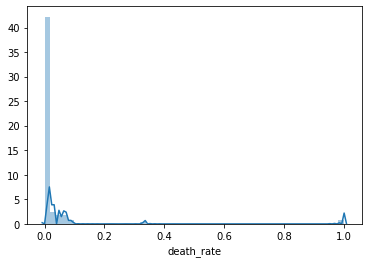

In [19]:
sns.distplot(summary_df.sort_values('confirmed_count', ascending=False)[1:]['death_rate'])

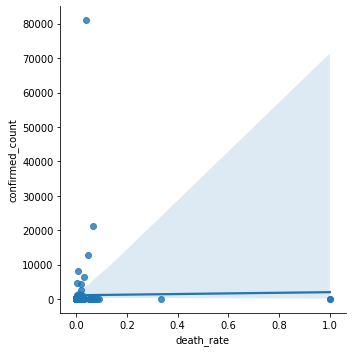

In [20]:
import seaborn as sns

sns.lmplot(x='death_rate', y='confirmed_count', data=summary_df)

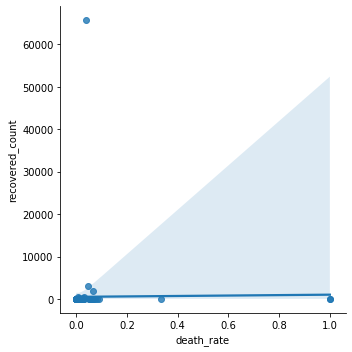

In [21]:
sns.lmplot(x='death_rate', y='recovered_count', data=summary_df)

In [22]:
summary_df[['confirmed_count', 'death_rate', 'recovered_rate']].corr() # very low correlation

,confirmed_count,death_rate,recovered_rate
confirmed_count,1.000000,0.015387,0.336880
death_rate,0.015387,1.000000,-0.032863
recovered_rate,0.336880,-0.032863,1.000000


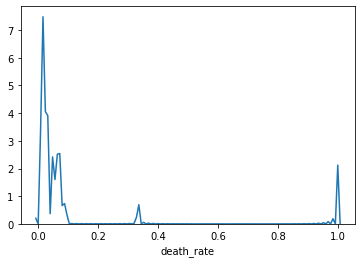

In [23]:
sns.distplot(summary_df['death_rate'], hist=False)

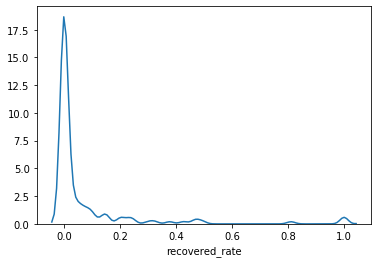

In [24]:
sns.distplot(summary_df['recovered_rate'], hist=False)

In [25]:
summary_df['death_rate']

country
Afghanistan                       0.0000
Albania                           0.0263
Algeria                           0.0811
Andorra                           0.0000
Antigua and Barbuda               0.0000
                                   ...  
United Kingdom                    0.0184
Uruguay                           0.0000
Venezuela                         0.0000
Vietnam                           0.0000
occupied Palestinian territory       NaN
Name: death_rate, Length: 143, dtype: float64

In [26]:
summary_df.loc['US']

confirmed_count    2727.0000
death_count          54.0000
death_rate            0.0198
recovered_count      12.0000
recovered_rate        0.0044
Name: US, dtype: float64